# AppStream Introduction for Developer

AppStream 2.0 is an AWS service that allows streaming of desktop applications to users. If you are not familiar with AppStream, this notebook covers some of the basic terminologies and functions that you might find useful. Then, you can start navigating the different image building reports according to your needs. 

Table of Content:

- [AppStream Terminology](#AppStream-Terminology)
- [Appstream Workflow](#Appstream-Workflow)
- [AppStream Features](#AppStream-Features)
- [Future Exploration](#Future-Exploration)

<div class="alert alert-block alert-info">
<b>Workflow:</b> Create an Image using image builder → Create a Fleet using the Image → Create a Stack associated with the Fleet → Create Users → Assign Stack to the users
</div>


## AppStream Terminology

- **Streaming / Fleet instance**: An EC2 instance available to a single user for application streaming. 
- **Image**: A snapshot of an EC2 instance consisting of applications that can be streamed to users, as well as default system and app settings.
- **Fleet**: Consists of multiple fleet instances / streaming instances ran by multiple users. 
- **Stack**: Contains an associated fleet, user access policies, and storage configurations. 
 
    
The streaming instances are never created directly in the console. Instead, they are managed through a stack, which has an associated fleet. This fleet is created based on a specific image, so all streaming instances launched from this stack will run the applications specified in that image.


- **Image builder**: An EC2 instance used to create images. An image builder will be launched from an existing image, applications will be installed in the image builder, and a new image containing the installed applications can be created. 

- **Instance families**: When launching an image builder or creating a fleet, you would need to specify an instance type that dictates the hardware that will be used when launching instances. There are multiple instance families which offer instance types that differ in compute, memory, and GPU capabilities. 


The persistent storage feature of a stack can be enabled to allow for a more consistent user experience. 

- **Enable Persistent Storage**: User settings will be saved accross sessions, such as user-set environment variables and files saved in Home Folder (User files saved in Temporary folder will not be saved). The settings will be saved in the stack's corresponding S3 bucket under a unique folder for each user (hash of username).  



## AppStream Workflow

### Create / Choose Image

Use the base images provided by AppStream, or checkout the respective notebooks on instructions to build images on your own. 

- [Windows-Conda-Sleap-Image](./Windows-Conda-Sleap-Image.ipynb): *Has detailed guide through image building process for windows*
- [Windows-Rclone-Imag](./Windows-Rclone-Image.ipynb)
- [Windows-DLC-Image](./Windows-DLC-Image.ipynb)
- [Linux-Conda-Sleap-Rclone-Image](./Linux-Conda-Sleap-Rclone-Image.ipynb)

P.S. VFS cacheing is not enabled in any of the rclone notebooks, since no significant improvement has been observed when analyzing large video files with Sleap with VFS cache enabled. 

### Create Fleet from Image

Important: remember to choose the same instance type as the image you want to use. 

When creating a fleet, you can choose Applications view or Desktop view. The only difference is that users can only open windows of the apps in App view, whereas in Desktop view, the users can additionally choose to see the standard desktop available on the OS. 

There are also different fleet types. On Demand costs less when fleet is running but no user streaming instances, but takes more time (~2min) to launch each streaming instance. 

This demo creates a stack using the Demo Image we created earlier, with App view and On-Demand fleet type. 

In deployment, disconnect time should be around 120 minutes and idle time should be 60 minutes.

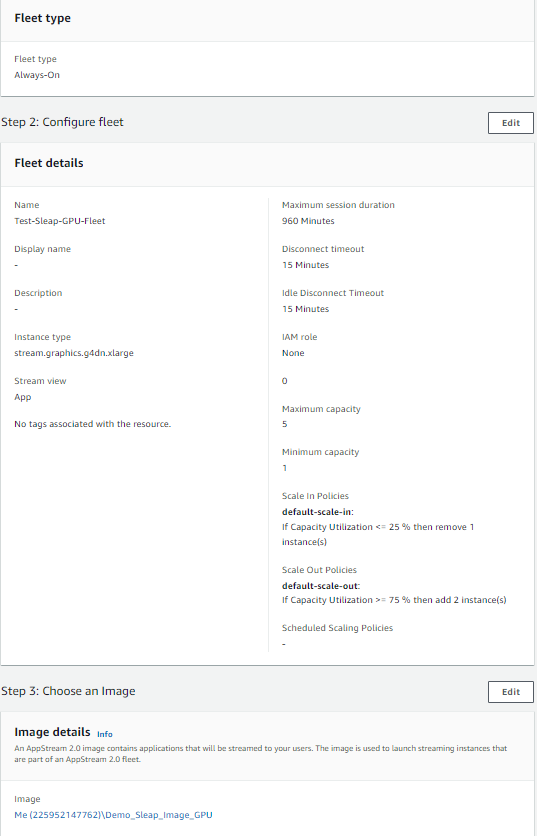

### Create Stack with Fleet

Create a stack and associate it with the fleet we just created. You may dissociate and associate fleets from stacks with ease after the stack has been created. For this image, we disabled Home Folder and Application Settings Persistence since these features require creating an S3 bucket to store user settings. If it were enabled, each user would be assigned a unique folder in the appstream bucket associated with this stack. Users can read and write to that folder from their fleet instance. In deployment, we would like to enable this feature so that users can store temporary files in the persistent home folder, and establish a separate procedure for them to upload files to the S3 buckets. 

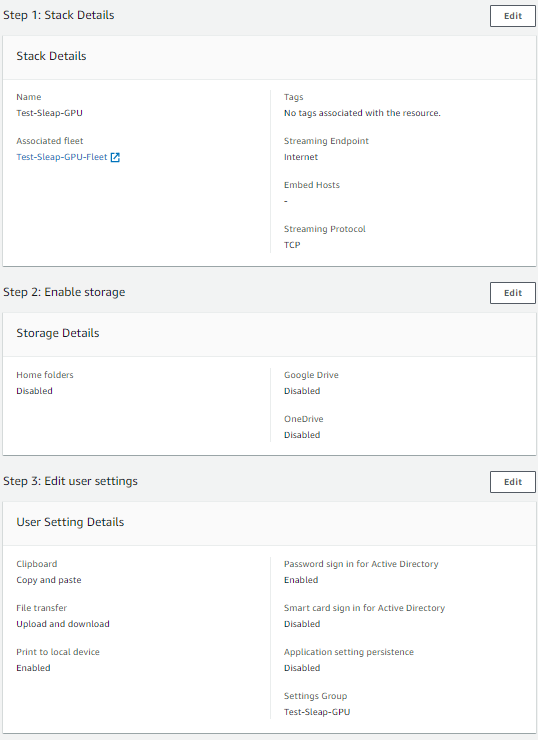

### Quickly Test App 

For quick testing, create temporary streaming URLs from the stack. Since App view is chosen for this demo, the user will only see the App's window against a black backgroudn. If the Desktop view was chosen, the user will see the App's window against a standard dekstop. filling up the display. For testing, we verified that the user can activate the sleap environment and launch the Sleap GUI successfully in this instance, then end the session. For more permanent user access options, see [the section on user access](#Provide-user-access-to-AppStream).

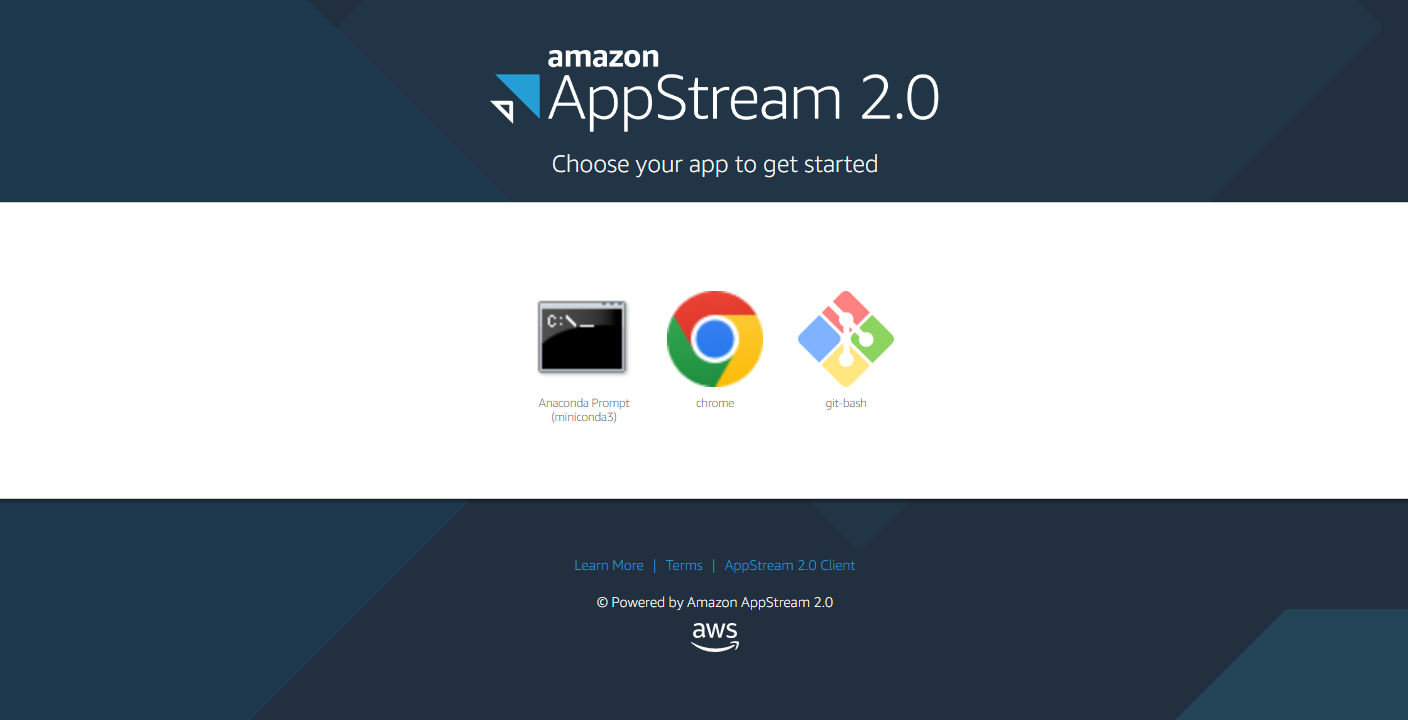

## AppStream Features

### Provide user access to Appstream

AppStream provides a built-in way of providing user access via User Pools. You may also manage users via Active Directory or SAML Federation. There are several solutions that use third-party SAML authentication, and we only explore Okta here as an example. See [here](https://docs.aws.amazon.com/appstream2/latest/developerguide/external-identity-providers-further-info.html) for more ways to integrate with SAML. 

1. **AppStream User Pool**

Manually add each user with their emails, and assign stacks to each user. The user will receive a log-in link and a temporary password. The user will be prompted to pick a new password on the first log-in attempt, but the log-in link will be permanent and so the user should save it somewhere secure. The user will then have access to the apps specified by the stack that was being added to the user. 

**You would have to attach an IAM role with other AWS service permissions to a fleet in order to give users access to those services.**

2. Terraform User Pool

You may use [Terraform](https://registry.terraform.io/providers/hashicorp/aws/latest/docs/resources/appstream_user) to add and manage users via User Pool as well. It is possible to manage many users at once with Terraform commands. 

It is easy to create a fleet, create a stack, and associate them in Terraform. More steps are needed to create fleet autoscaling policies in Terraform than in the Console, since it requires setting up CloudWatch Alarms separately. However, it is much more complicated to automate image building in Terraform, so this option is pushed back for the future. 


3. Okta

It is possible to [setup SAML for Appstream](https://docs.aws.amazon.com/appstream2/latest/developerguide/external-identity-providers-setting-up-saml.html) so that users can log in with existing credentials and stream apps. Specifically, instructions to [integrate Appstream with Okta](https://saml-doc.okta.com/SAML_Docs/How-to-Configure-SAML-2.0-for-Amazon-AppStream-2-0.html) is carefully documented. 

**Okta will be in charged of managing users' permissions to access AWS services such as S3 buckets.**

Steps to setup:

- Add Okta as Identity Provider in AWS. 
- Create Role to establish trust between Okta and Appstream, so users authenticated by Okta can access an AppStream Stack. 
- Configure Okta to add AppStream. P.S. You will need admin access in Okta.

4. *Active Directory User*


### Provide Access to S3 data via IAM role

For this demo, we will provide users and image builders access to S3 data by first Authenticating Users via AppStream User Pool, then Providing access via Configuring Fleets with IAM role. 

As mentioned in instructions to [Configure Appstream Fleets](https://docs.aws.amazon.com/appstream2/latest/developerguide/set-up-stacks-fleets.html), you can apply an IAM role to an AppStream fleet, so that users can make AWS API requests from the fleet instance without manually managing AWS credentials. In fact, AppStream will create temporary AWS credentials behind the scene to enable users to make those requests. The credentials will be created under the profile name **appstream_machine_role**, so whenever a user launches a fleet instance and wants to access AWS services, they must user this profile name. 

[This page](https://docs.aws.amazon.com/appstream2/latest/developerguide/using-iam-roles-to-grant-permissions-to-applications-scripts-streaming-instances.html#how-to-create-iam-role-to-use-with-streaming-instances) details the instructions of creating an IAM role with the desired S3 permissions. For this demo, a **appstream_data_bucket__role** role was created with limited permissions to read and write an appstream S3 bucket. This role is attached when creating the fleet so that users can access S3 resources. 

There are two primary ways of accessing AWS servies with a profile: AWS CLI, and Python Boto3. Here are some simple examples of how to use them to upload a file to the S3 bucket and list objects in the bucket to confirm it has been uploaded. You would need a `FILE_PATH` that points to the location of the file in the fleet instance and a `BUCKET_NAME` to perform these operations. See [the section on Upload Local Files](##Upload-Local-Files-to-AppStream) for more instructions on how to upload a local file to the fleet instance and obtain the `FILE_PATH`. 

**AWS CLI**
    
Since we have already set the environment variable `AWS_PROFILE="appstream_machine_role"` during the image building phase, users can run the following commands in the command line. 

    aws s3 cp FILE_PATH s3://BUCKET_NAME 
    aws s3 ls s3://BUCKET_NAME 

If the environment variable `AWS_PROFILE` was not set, users would have to run the commands with an additional flag. 

    aws s3 cp FILE_PATH s3://BUCKET_NAME --profile appstream_machine_role
    aws s3 ls s3://BUCKET_NAME --profile appstream_machine_role

**Boto3**

Boto3 is AWS SDK Client for Python, and it must be installed during the Image Building phase as an Admin user (run `pip install boto3` in Anaconda Command Prompt). Then uers can run the following commands in the command line.


    import boto3
    
    # using client interface
    s3_client = boto3.client('s3')
    s3_client.upload_file(FILE_PATH, BUCKET_NAME, OBJECT_NAME)
    objects = s3_client.list_objects(Bucket=BUCKET_NAME)
    for obj in objects['Contents']:
        print(obj['Key'])
    
    # using resource interface
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(BUCKET_NAME)
    object = bucket.Object(key=OBJECT_NAME).put(Body=open(FILE_PATH, 'rb'))
    for obj in bucket.objects.all():
        print(obj.key)
        
Similarly, if the environment variable `AWS_PROFILE` was not set, users would have to run the following code instead. 

    # using client interface
    session = boto3.Session(profile_name='appstream_machine_role')
    s3_client = session.client('s3')
    # the rest is the same
    
    # using resource interface
    session = boto3.Session(profile_name='appstream_machine_role')
    s3 = session.resource('s3')
    # the rest is the same

### Upload Local Files to AppStream

Note that the Upload action must be enabled when configuring the fleet. When a user is in a fleet instance, they can click on the `My Files` icon on the upper left, and upload files into the Template Folder by dragging them from the local computer or using the `Upload Files` button. The uploaded files will then be stored under the `C:\Users\PhotonUser\My Files\Temporary Files` folder. 

For this demo, a folder `user-name` is created under `Temporary Files` and a video is uploaded to `user-name`. 
Hence `FILE_PATH="Users\PhotonUser\My Files\Temporary Files\louise-xu\centered_pair_small.mp4"`. However, if you would like the users to upload the entire username folder along with the video subfiles, cd to the `My Files` directory and run the following AWS CLI command for recursive upload. 

    aws s3 cp "Temporary Files" s3://BUCKET_NAME --recursive

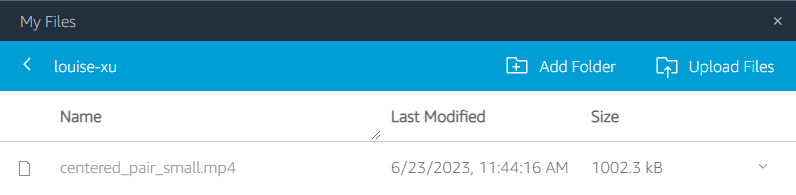

### Provide access to S3 Data via S3FS

Alternatively, S3FS allows users to mount S3 buckets onto the user file system so that they can access the S3 bucket contents just like any other files. See more detailed instructions under the Linux Platform section. 

## Future Exploration


In the future, we could explore the possibility of storing Sleap as an app block (aka a virtual harddisk) in order to create Elastic fleet instances. 

- Always-on fleet: streaming instances are preconfigured with apps, instances run all the time even when no users are streaming, users start streaming immediately after choosing an app / desktop.
- On-Demand fleet: streaming instances are preconfigured with apps, instances only run when users are streaming, users start streaming after 1-2 min wait. 
- Elastic fleet: users select app / desktop to launch and app block has been downloaded and mounted to instance, users start streaming